In [1]:
# Python
import pandas as pd
import numpy as np
from fbprophet import Prophet

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [2]:
from wikipedia_kaggle import load_wikipedia_dataframe

wiki_df = load_wikipedia_dataframe()
#wiki_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,pagename,lang,access_type,agent
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,14.0,20.0,22.0,19.0,18.0,20.0,2NE1,zh,all-access,spider
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,9.0,30.0,52.0,45.0,26.0,20.0,2PM,zh,all-access,spider
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,4.0,6.0,3.0,4.0,17.0,3C,zh,all-access,spider
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,16.0,11.0,17.0,19.0,10.0,11.0,4minute,zh,all-access,spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,zh,all-access,spider


In [98]:
#plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
#wiki_df.loc[wiki_df['agent'] == 'spider'].iloc[3][1:-4].plot()

In [99]:
date_stamps = list(wiki_df.axes[1][1:-4])
train_date_stamps = date_stamps[:489]
test_date_stamps = date_stamps[489:]

future_df = pd.DataFrame(data={'ds':test_date_stamps}) #Dataframe to be used for forecast

In [100]:
def get_page_dfs(ind):
    page_name = wiki_df.iloc[ind]['Page']
    values = wiki_df.iloc[ind].drop(['Page', 'lang', 'access_type', 'agent', 'pagename']).tolist()
    
    #print(values, len(values))
    
    train_df = pd.DataFrame(data={'ds':train_date_stamps, 'y':values[:489]})
    test_df = pd.DataFrame(data={'ds':test_date_stamps, 'y':values[489:]})
    
    return page_name, train_df, test_df

In [101]:
#page_name, train_df, test_df = get_page_dfs(0)

In [102]:
def get_forecast_data(ind, print_graph=False, yearly_seasonality=None):
    page_name, train_df, test_df = get_page_dfs(ind) #Get page data and dataframes
    
    #print(page_name)
    #print(train_df)
    #print(test_df)
    
    
    m = Prophet(yearly_seasonality=yearly_seasonality, uncertainty_samples = 0)
    m.fit(train_df) #Train classifier
    
    forecast = m.predict(future_df)
    
    forecast['yhat'] = forecast['yhat'].clip(lower=0, axis=0) #Ensure negative values go 0
    
    forecast_values = forecast['yhat'].as_matrix()
    right_values = np.nan_to_num(test_df['y'].as_matrix())
    
    if print_graph:
        print(page_name)
        plt.plot(forecast_values, label='Forecast')
        plt.plot(right_values, label='Correct')
        plt.legend()
        plt.show()

    #Calculate mean squared error
    #print(forecast_values, right_values)
    mse = np.mean((forecast_values-right_values)**2)
    
    return page_name, mse

In [103]:
#mse = get_forecast_data(82, True, True)
#print(mse)

In [106]:
from IPython.display import clear_output

def benchmark_performance(ys, n_samples):#Flag for yearly seasonality
    mse_list = list()
    highest_mse = (0,"null",0)
    for i in range(n_samples):
        #clear_output(wait=True)
        print("Working on index: {}/{}".format(i+1, n_samples))
        try:
            page_name, mse = get_forecast_data(i, False, ys)
            
            if mse > highest_mse[2]:
                highest_mse = (i, page_name, mse)            
            
            mse_list.append(mse)

        except TypeError as e:
            print(e)
    
    return mse_list, highest_mse

Working on index: 200/200
Wall time: 1min 17s
MSE mean: 58888.078240523166
(139, 'Special:Search_zh.wikipedia.org_all-access_spider', 11040157.521885332)


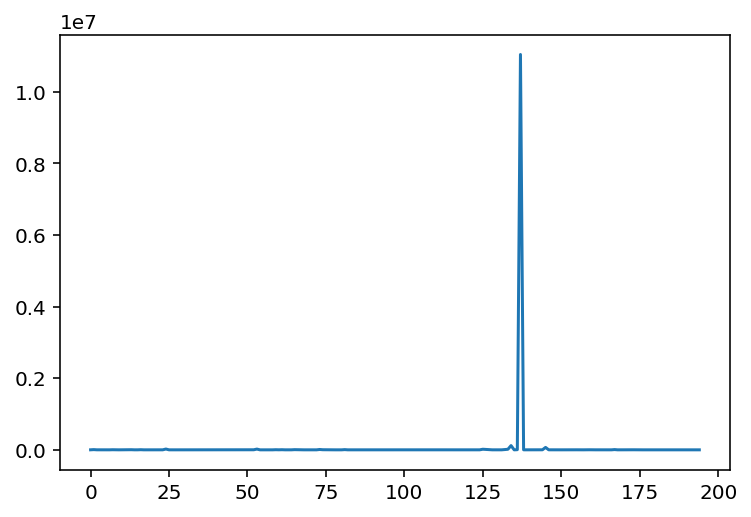

In [105]:
%time mse_list_ys, highest_mse = benchmark_performance(True, 200)
plt.plot(mse_list_ys)
print("MSE mean: {}".format(np.mean(mse_list_ys)))
print(highest_mse)

Working on index: 200/200
Wall time: 1min 11s
MSE mean: 3924.2176076850974
(139, 'Special:Search_zh.wikipedia.org_all-access_spider', 504389.88524590165)


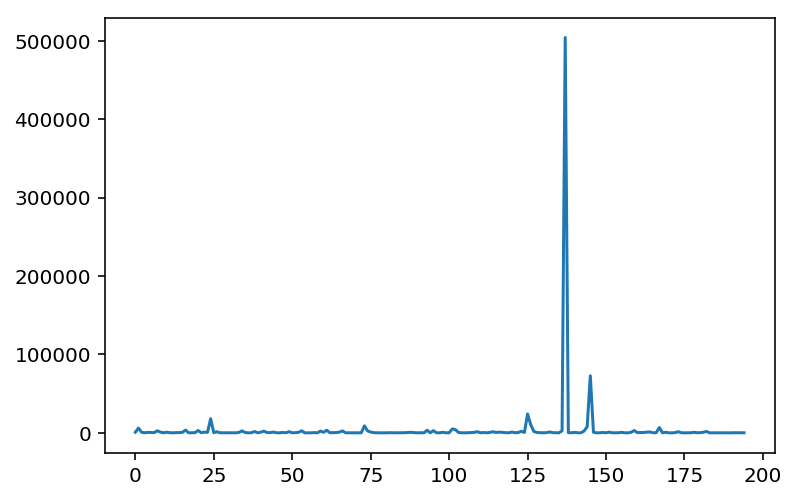

In [68]:
%time mse_list, highest_mse = benchmark_performance(False, 200)
plt.plot(mse_list)
print("MSE mean: {}".format(np.mean(mse_list)))
print(highest_mse)

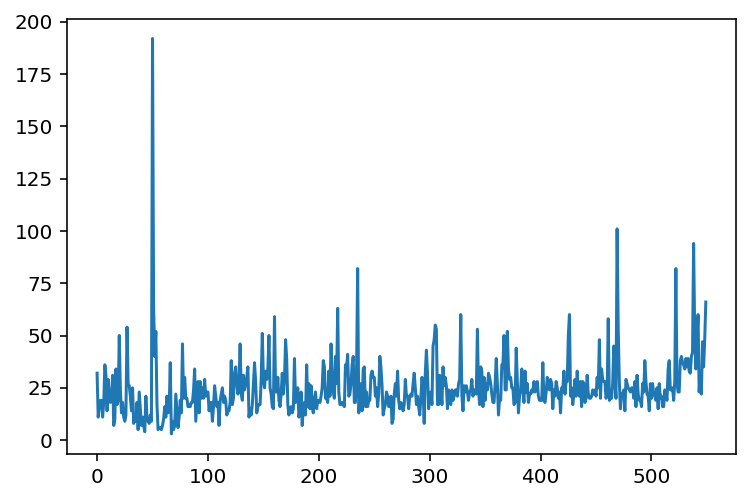

In [81]:
plt.plot(wiki_df.iloc[140].values[1:-4])

In [80]:
wiki_df.iloc[139].values[1:-4]

array([17.0, 18.0, 8.0, 16.0, 14.0, 9.0, 13.0, 18.0, 11.0, 7.0, 4.0, 12.0,
       7.0, 11.0, 11.0, 11.0, 12.0, 19.0, 11.0, 13.0, 14.0, 10.0, 8.0,
       10.0, 3.0, 8.0, 11.0, 13.0, 10.0, 1.0, 3.0, 9.0, 8.0, 8.0, 7.0,
       10.0, 19.0, 13.0, 18.0, 19.0, 19.0, 8.0, 14.0, 16.0, 16.0, 12.0,
       9.0, 10.0, 11.0, 5.0, 12.0, 15.0, 16.0, 27.0, 14.0, 25.0, 14.0,
       12.0, 13.0, 14.0, 9.0, 7.0, 7.0, 9.0, 6.0, 3.0, 2.0, 5.0, 5.0, 17.0,
       18.0, 12.0, 9.0, 12.0, 15.0, 9.0, 4.0, 180.0, 165.0, 276.0, 124.0,
       170.0, 132.0, 1713.0, 1651.0, 1918.0, 1467.0, 1954.0, 1733.0, 789.0,
       1800.0, 568.0, 759.0, 735.0, 216.0, 413.0, 289.0, 554.0, 372.0,
       508.0, 1918.0, 2820.0, 949.0, 1187.0, 2398.0, 2851.0, 2465.0,
       6394.0, 4863.0, 2077.0, 881.0, 2801.0, 1130.0, 1158.0, 523.0, 395.0,
       171.0, 122.0, 700.0, 1362.0, 1975.0, 2907.0, 3347.0, 7032.0, 9498.0,
       7454.0, 6627.0, 6360.0, 3927.0, 2704.0, 1693.0, 1894.0, 1685.0,
       2435.0, 326.0, 2051.0, 3743.0, 8528.0, 11343

Special:Search_zh.wikipedia.org_all-access_spider


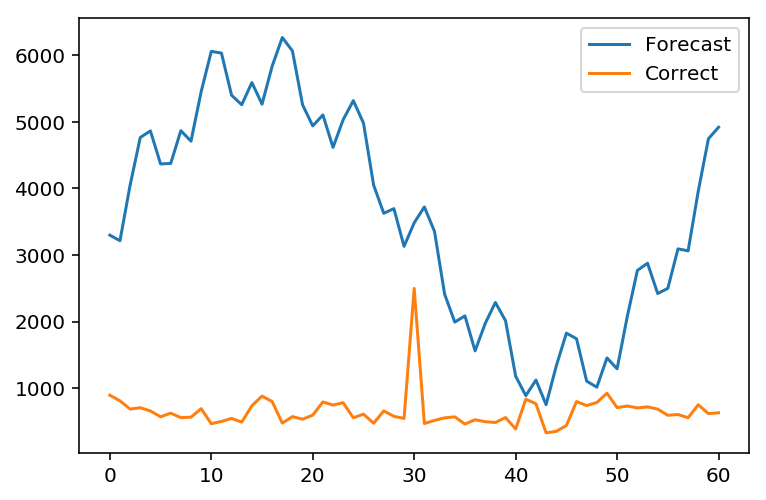

('Special:Search_zh.wikipedia.org_all-access_spider', 11040157.521885332)

In [71]:
get_forecast_data(139, True, True)